In [241]:
import os
from os.path import join as join

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from umap import UMAP

import numpy as np
import pandas as pd
import shap

import config_local as cl
import ShapCalc

# Loading the combined results

In [ ]:
risk_dir = join(cl.PREDICTIONS_PATH,'RiskScores')
all_results = cl.load_pickle(join(risk_dir, 'combined_results.pickle'))

# all_results

## Extracting the different model's metrics

In [7]:
metrics_tree = pd.json_normalize(all_results.metrics_tree)
metrics_tree.index = all_results.index

metrics_lasso = pd.json_normalize(all_results.metrics_lasso)
metrics_lasso.index = all_results.index

metrics_lasso

,Coefficient_of_determination,explained_variance_score,pearson_r,pearson_p_value,spearman_r,spearman_p_value
lean_mass_index,0.508644,0.508799,[0.7133205315299039],2.143595e-109,0.725783,5.125652e-115
appendicular_lean_mass,0.583527,0.583549,[0.7640435822815674],8.649338e-135,0.775160,3.778755e-141
appendicular_lean_mass_index,0.517625,0.517882,[0.7197886027440054],2.830795e-112,0.734082,6.178511e-119
visceral_fat_mass,0.579305,0.579309,[0.7611600224701914],3.993833e-131,0.789404,1.614759e-147
visceral_fat_volume,0.579305,0.579309,[0.7611600224701682],3.993833e-131,0.789404,1.614759e-147
visceral_fat_area,0.587768,0.587774,[0.7668545290161061],3.050657e-134,0.789906,7.837297e-148
waist_to_hip_ratio,0.421139,0.421140,[0.6490947373491388],6.149451e-133,0.657245,2.205966e-137
fat_mass_index,0.705635,0.706668,[0.8424939144736951],6.988788e-189,0.859239,1.728921e-204
total_fat_percent,0.750169,0.750684,[0.8678011169864945],7.049403e-214,0.876650,1.182315e-223
android_gynoid_ratio,0.560476,0.560907,[0.7491625194767007],8.311532e-127,0.777397,1.792393e-142


# Plots

In [153]:
sns.set_theme()
plt.rcParams['figure.figsize']=[15,5]

## Pearson_r comparison for both LGBM and LassoCV

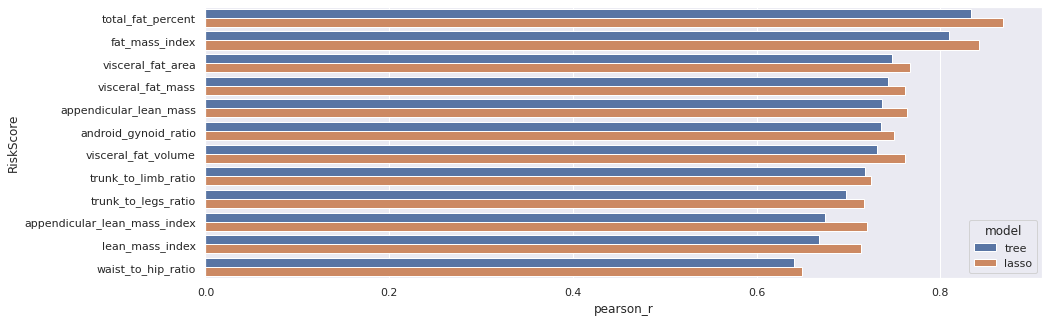

In [158]:
pearson_tree = pd.DataFrame(metrics_tree.pearson_r.apply(lambda x: x[0]), index = metrics_tree.index)
pearson_tree = pearson_tree.sort_values(by='pearson_r' ,ascending=False)
pearson_lasso = pd.DataFrame(metrics_lasso.pearson_r.apply(lambda x: x[0]), index = metrics_lasso.index)
pearson_lasso = pearson_lasso.sort_values(by='pearson_r' ,ascending=False)

pearson_data = pd.concat([pearson_tree, pearson_lasso], axis=0, keys=['tree','lasso'])
pearson_data = pd.concat([pearson_data, pearson_data.index.to_frame(name=['model', 'RiskScore'])], axis=1)

pearson_bar_plot = sns.barplot(x=pearson_data.pearson_r, y=pearson_data.RiskScore, hue=pearson_data.model)

plt.savefig(join(cl.PLOTS_PATH, 'RiskScores', 'pearson_r_LGBM_Lasso_BarPlot.png'), bbox_inches='tight')


## Scatter Plots of test vs predicted outcomes

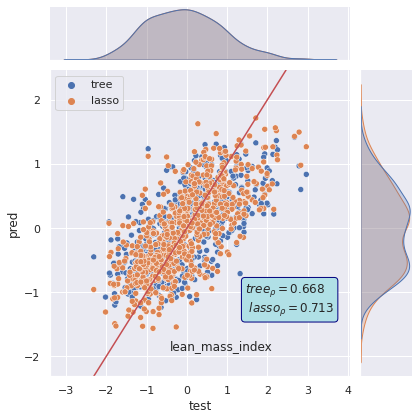

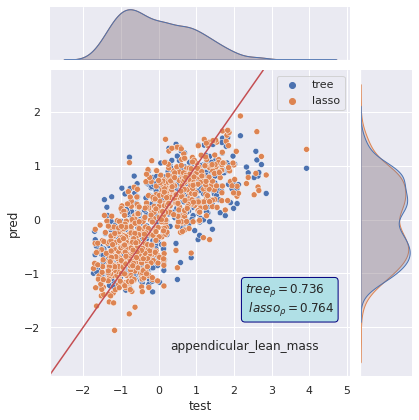

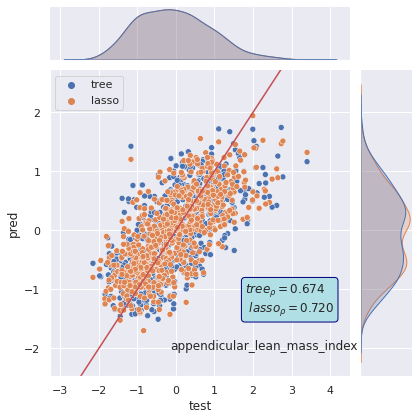

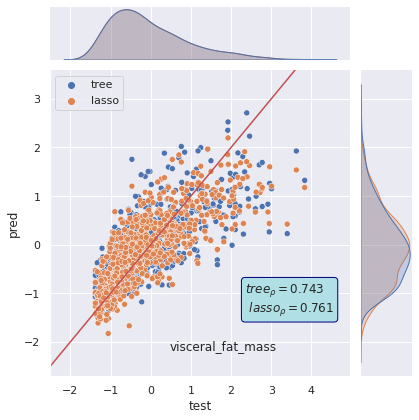

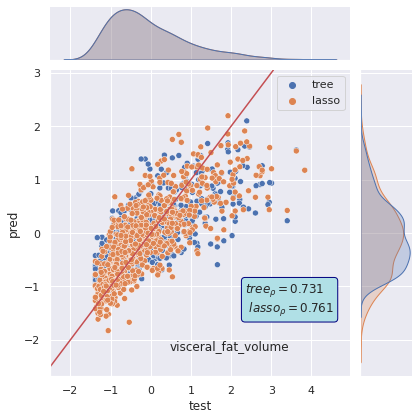

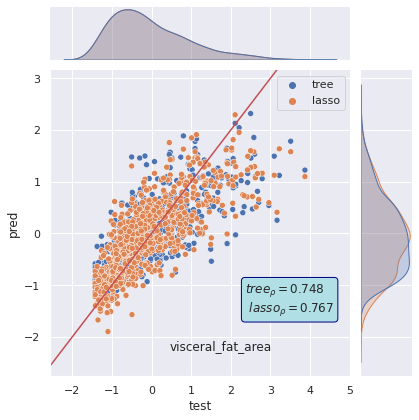

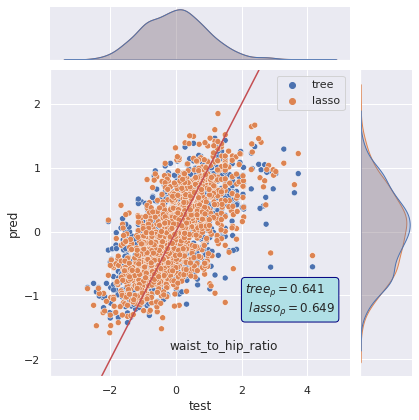

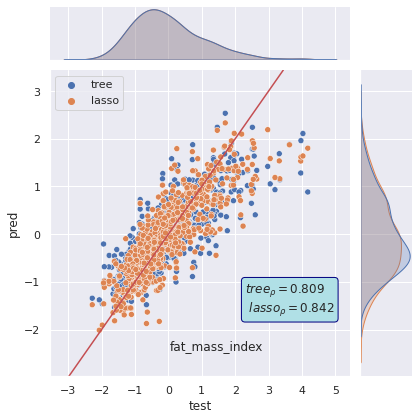

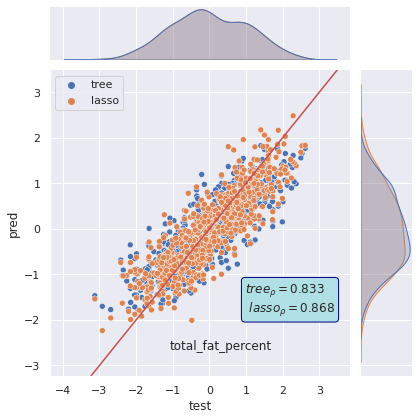

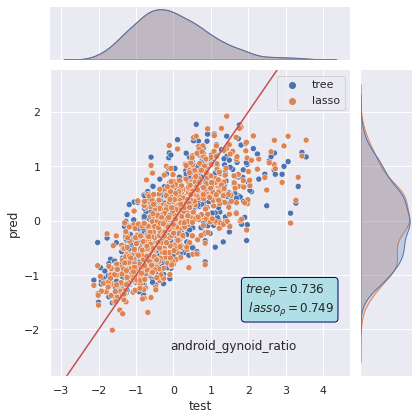

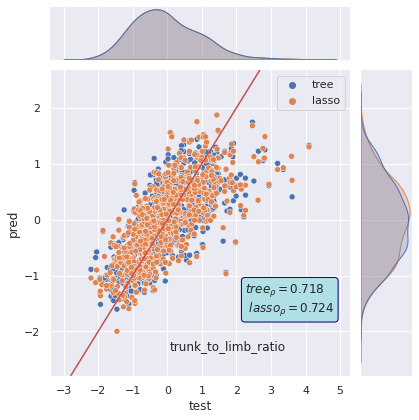

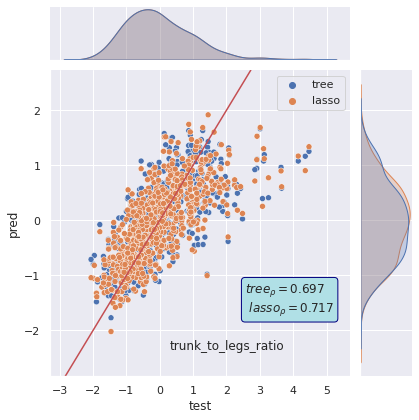

In [114]:
for rs in all_results.index.to_list():
    data = all_results.loc[rs]
    test = data.loc['y_test']
    pred_tree = data.loc['y_pred_tree']
    pred_lasso = data.loc['y_pred_lasso']
    test = pd.DataFrame(test)
    pred_tree = pd.DataFrame(pred_tree, index=test.index, columns=[rs])
    pred_lasso = pd.DataFrame(pred_lasso, index=test.index, columns=[rs])

    pred_data = pd.concat([pred_tree, pred_lasso], keys=['tree', 'lasso'])
    # pd.concat([test, pred_data], axis=0)
    test_data = pd.concat([test, test], keys=['tree', 'lasso'])

    data_tmp = pd.concat([test_data, pred_data], axis=1)
    data_tmp.columns = ['test', 'pred']

    g = sns.jointplot(data=data_tmp, x='test', y='pred', hue=data_tmp.index.get_level_values(0))

    g.set_axis_labels('test', 'pred')
    g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')
    g.ax_joint.annotate(f'$tree_\\rho = {metrics_tree.loc[rs].pearson_r[0]:.3f}$  \n $lasso_\\rho = {metrics_lasso.loc[rs].pearson_r[0]:.3f}$',
                    xy=(0.65, 0.25), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    g.ax_joint.annotate(rs,
                    xy=(0.4, 0.1), xycoords='axes fraction',
                    ha='left', va='center')

    g.savefig(os.path.join(cl.PLOTS_PATH,'RiskScores',f'{rs}_LGBM_Lasso_ScatterPlot'))

# all_results.T[rs].loc['y_test'].shape

## Model Diff

In [292]:
diff_data

       RegistrationCode
tree   10K_4212035135      0.503208
       10K_8575080180     -0.057985
       10K_7729190876     -0.388845
       10K_5459378019      0.571918
       10K_7046133717      1.135445
                             ...   
lasso  10K_4200860465     -0.244309
       10K_1357699622     -0.162424
       10K_8608337893     -0.547967
       10K_9004924068     -0.850156
       10K_9886175034     -0.615107
Length: 1394, dtype: float64

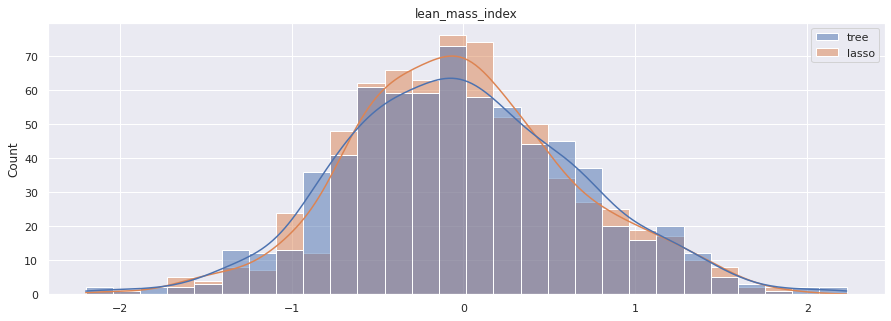

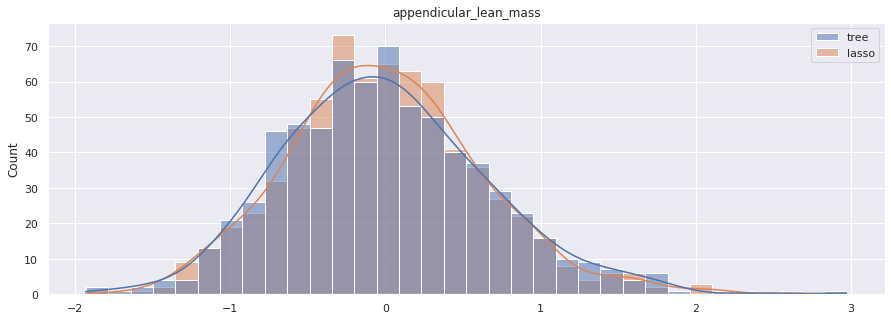

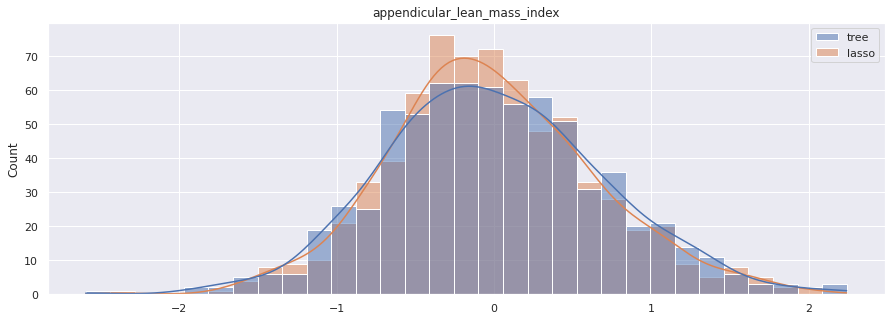

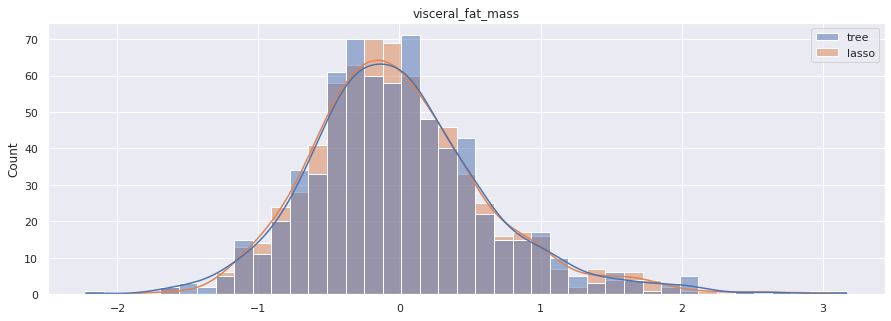

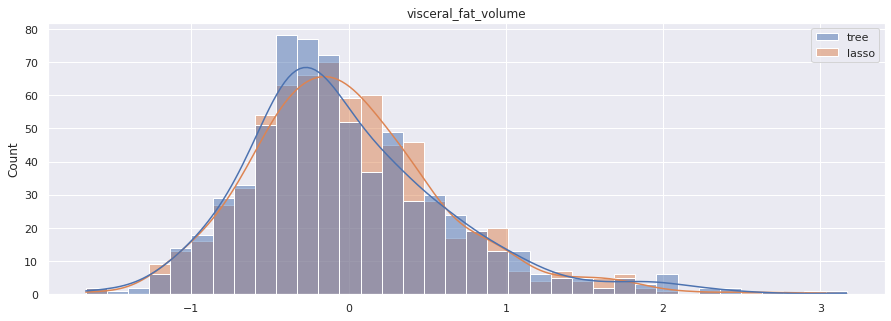

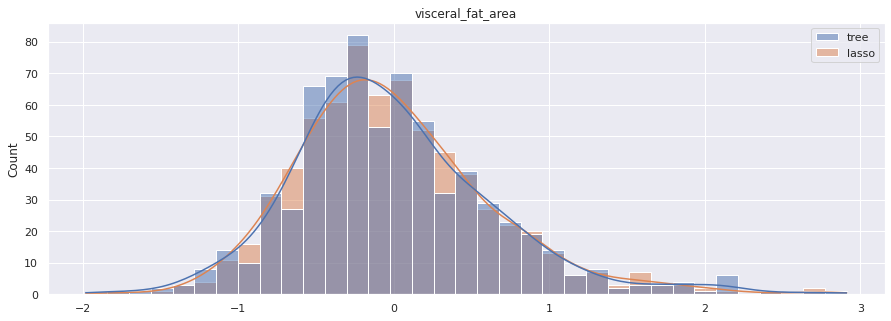

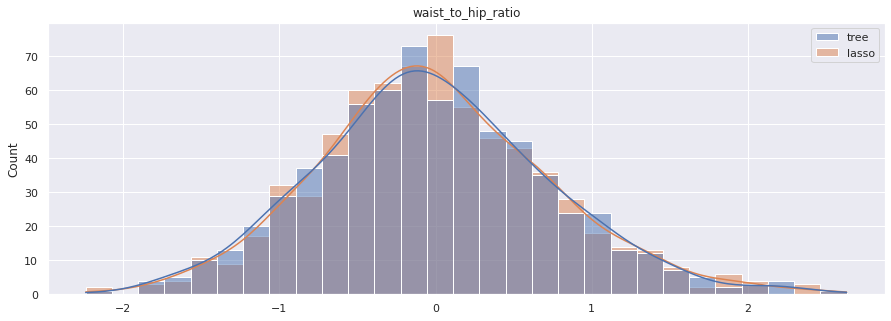

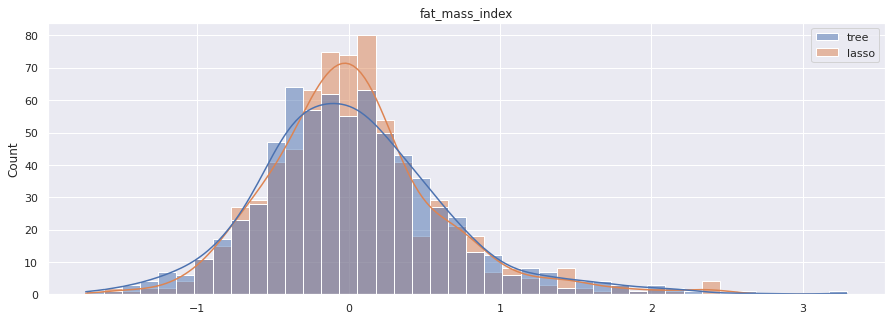

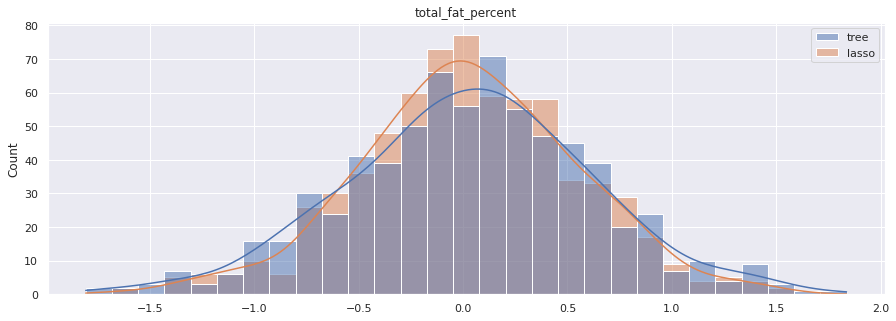

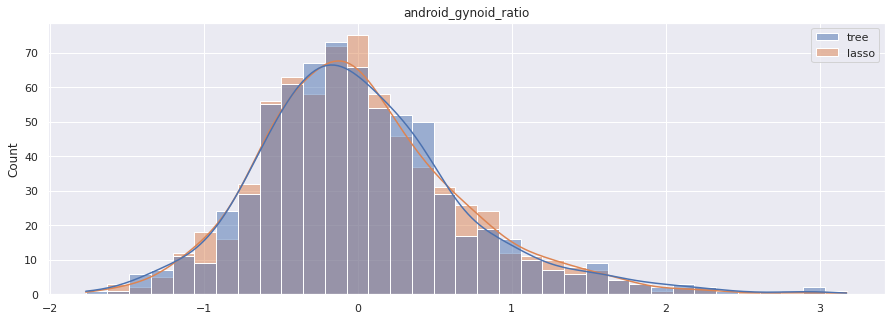

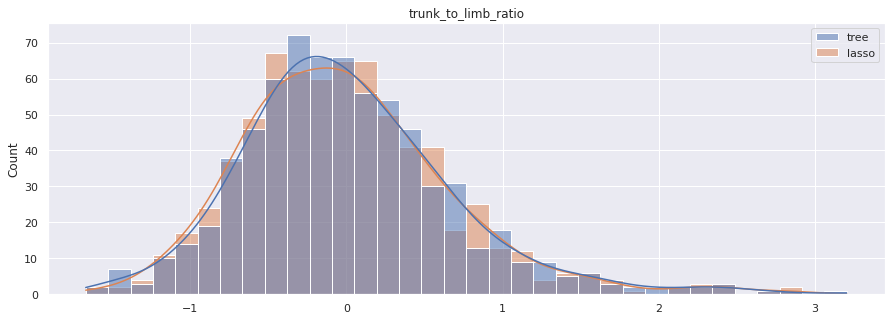

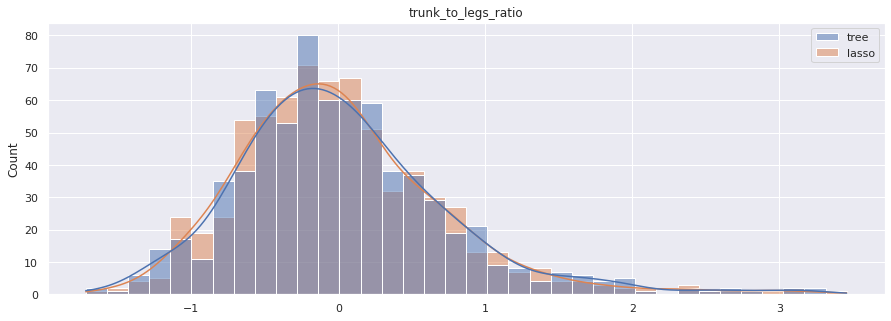

In [309]:
diff_test_pred = pd.DataFrame()
for rs in all_results.index.to_list():
    data = all_results.loc[rs]
    test = data.loc['y_test']
    pred_tree = pd.Series(data.loc['y_pred_tree'], index = test.index)
    pred_lasso = pd.Series(data.loc['y_pred_lasso'], index = test.index)

    test = pd.DataFrame(test)
    pred_tree = pd.DataFrame(pred_tree, index=test.index, columns=[rs])
    pred_lasso = pd.DataFrame(pred_lasso, index=test.index, columns=[rs])

    diff_test_pred['tree'] = test[rs] - pred_tree[rs]
    diff_test_pred['lasso'] = test[rs] - pred_lasso[rs]

    diff_data = pd.concat([diff_test_pred['tree'], diff_test_pred['lasso']], keys=['tree', 'lasso'])

    hp = sns.histplot(x=diff_data, hue=diff_data.index.get_level_values(0).to_list(), kde=True)
    hp.set_title(rs)

    hp.figure.savefig(join(cl.PLOTS_PATH, 'RiskScores', f'{rs}_test_diff_pred_LGBM_Lasso_HistPlot.png'))

    # sns.histplot(data = diff_test_pred.tree)
    # sns.histplot(data = diff_test_pred.lasso)
    plt.show()

# Raw Data Clustering

## PCA

In [ ]:
pca_raw = PCA(n_components=400)
pca_fit_raw = pca_raw.fit(x_test)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## SHAP

In [228]:
models_tree = all_results.model_tree
models_lasso = all_results.model_lasso

x_test = all_results.x_test


shap_df_tree = {}#pd.DataFrame()
shap_df_lasso = {} #pd.DataFrame()

abs_mean_df_tree = {}#pd.DataFrame()
abs_mean_df_lasso = {}#pd.DataFrame()

for rs in models_tree.index:
    x_test_rs = x_test.loc[rs]

    explainer_tree = shap.explainers.Tree(models_tree.loc[rs], x_test_rs)
    shap_values_tree = explainer_tree.shap_values(x_test_rs, check_additivity=False)

    shap_df_tmp_tree = pd.DataFrame(shap_values_tree, columns=x_test_rs.columns, index=x_test_rs.index)
    shap_df_tree[rs] = shap_df_tmp_tree

    abs_mean_tmp_tree = shap_df_tmp_tree.abs().mean(axis='index')
    abs_mean_df_tree[rs] = abs_mean_tmp_tree


    # explainer_tree = ShapCalc.shapExplainer(models_tree.loc[rs])
    # explainer_lasso = ShapCalc.shapExplainer(models_lasso.loc[rs])

    # shap_values_tree = ShapCalc.shapValues(explainer_tree, x_test_rs)
    # shap_values_lasso = ShapCalc.shapValues(explainer_lasso, x_test_rs)

    # shap_df_tmp_tree = ShapCalc.shapDF(shap_values_tree, x_test_rs)
    # shap_df_tmp_lasso = ShapCalc.shapDF(shap_values_lasso, x_test_rs)

    # shap_df_tree.loc[rs] = shap_df_tmp_tree
    # shap_df_lasso.loc[rs] = shap_df_tmp_lasso

    # abs_mean_tmp_tree = ShapCalc.column_abs_mean(shap_df_tmp_tree)
    # abs_mean_tmp_lasso = ShapCalc.column_abs_mean(shap_df_tmp_lasso)

    # abs_mean_df_tree.loc[rs] = abs_mean_tmp_tree
    # abs_mean_tmp_lasso.loc[rs] = abs_mean_tmp_lasso



 99%|===================| 693/699 [00:30<00:00]          

## Create a 3-d numpy tensor, each layer is a DF, and all risk scores are stacked in the thirs dim
Taking the intersection of all the SHAP_values dataframes

In [260]:
# all_shap_df_tree = pd.concat(shap_df_tree.values())
# all_shap_df_tree

for i, k in enumerate(shap_df_tree.keys()):
    if i == 0:
        inter = shap_df_tree[k].index
    else:
        inter = inter.intersection(shap_df_tree[k].index)


shap_df_tree_to_np = {}
for k in shap_df_tree.keys():
    shap_df_tree_to_np[k] = shap_df_tree[k].loc[inter]


shap_3d = np.stack(list(shap_df_tree_to_np.values()))

### PCA
Creating Scree Plot

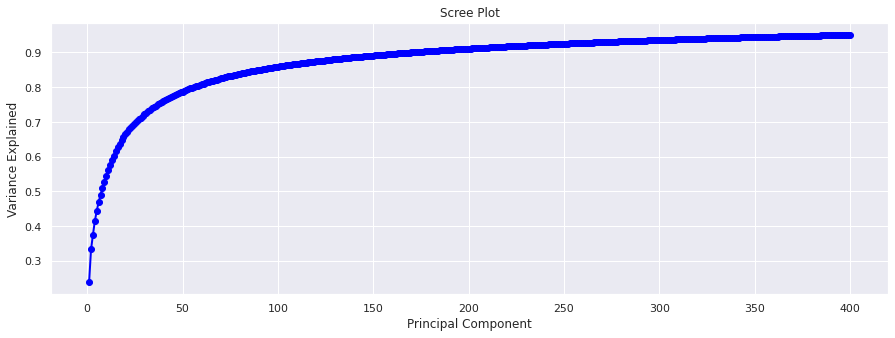

In [264]:

clustering_data = all_shap_df_tree#.drop(columns=['gender','age'])

pca = PCA(n_components=400)
pca_fit = pca.fit(clustering_data)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Clustering and dim-reduction with umap & tsne

In [247]:

n_components = 128
n_clusters = 6

clusters =[]
clusters.append(KMeans(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
clusters.append(SpectralClustering(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
shap_2d = UMAP(n_components=2).fit_transform((pca_fit.transform(clustering_data)[:, :n_components]))
tsne = TSNE(n_components=2).fit_transform((pca_fit.transform(clustering_data)[:, :n_components]))

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


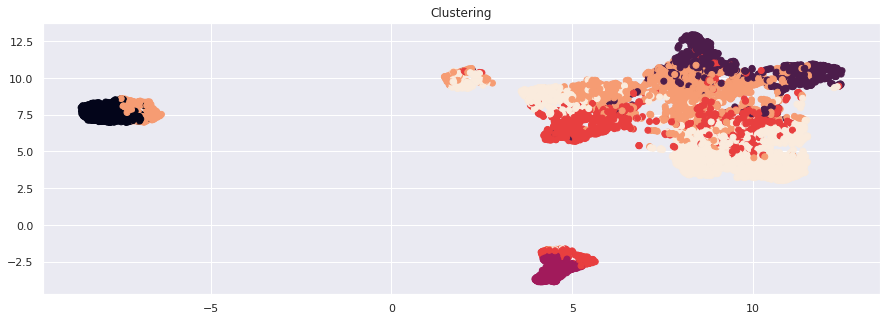

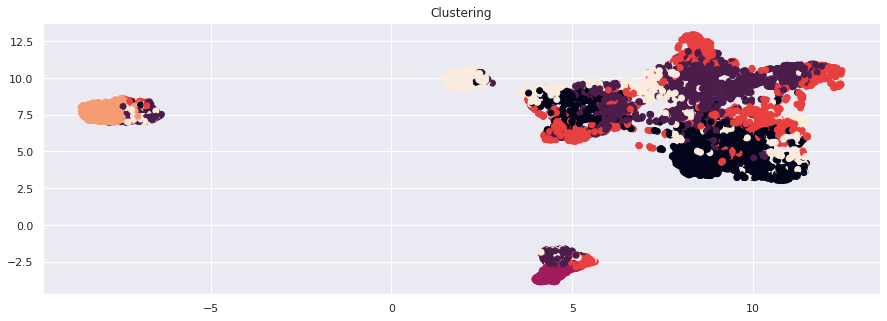

In [248]:
for i in range(len(clusters)):
    plt.scatter(shap_2d[:,0], shap_2d[:,1], c=clusters[i].labels_)
    plt.title('Clustering')
    plt.show()

# Debugging

In [203]:
import lightgbm as lgb

reg_tmp = cl.load_pickle(join(cl.PREDICTIONS_PATH,'SM_to_RiskScores','android_gynoid_ratio','Model.pickle'))
x_tmp = cl.load_pickle(join(cl.PREDICTIONS_PATH,'SM_to_RiskScores','android_gynoid_ratio','x_test.pickle'))
# type(models_tree.loc[rs].get_params())
# reg_tmp.set_params(**models_tree.loc[rs].get_params())

explainer_tmp = ShapCalc.shapExplainer(reg_tmp)
ShapCalc.shapValues(explainer_tmp, x_tmp)

array([[-3.57110707e-04, -8.97031755e-06, -2.74526259e-05, ...,
         2.26846574e-05, -8.98079657e-06,  6.60846157e-04],
       [ 4.24953554e-04, -8.97031755e-06, -1.53853401e-04, ...,
         1.76054048e-04, -6.80003518e-06, -1.52013704e-04],
       [-4.47346128e-04,  1.02219898e-05, -5.38815970e-05, ...,
        -7.37046052e-06,  1.15935785e-04,  3.61535230e-05],
       ...,
       [-2.40410891e-04,  1.02219898e-05, -8.76233612e-05, ...,
        -6.42661539e-05,  2.60454178e-05, -2.12462372e-04],
       [ 4.11087513e-04, -1.74837429e-05,  5.55792307e-05, ...,
        -2.65192652e-05, -4.40031253e-06,  2.48014919e-04],
       [ 5.85064903e-05,  1.76864210e-04, -1.81745198e-04, ...,
        -1.90629632e-05, -1.22254640e-05,  1.74405032e-04]])

In [224]:
# ShapCalc.shapValues(explainer_tree, x_test_rs)
# ShapCalc.shapExplainer(models_tree.loc[rs])
models_tree.loc[rs].get_params()
models_tree.loc[rs].booster_
mtmp = models_tree.loc[rs]
type(reg_tmp)
type(models_tree.loc[rs])

# print(reg_tmp.get_params())
# print(models_tree.loc[rs].get_params())

# ShapCalc.shapValues(ShapCalc.shapExplainer(mtmp), x_test_rs)
# explainer_tree.shap_values(x_test_rs)

# ShapCalc.shapExplainer(models_lasso.loc[rs])


shap.explainers.Linear(models_lasso.loc[rs], x_test_rs)(x_test_rs)
# shap.explainers.Tree(models_tree.loc[rs], x_test_rs).shap_values(x_test_rs, check_additivity=False)

.values =
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

.base_values =
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, na